In [39]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

In [40]:
class Model:
    # data
    
    # function
    
    # normal model without boundary condition and input parameters are the size of model(meter) and array(1)(x,z),
    # the velocity of P wave and S wave and the density, respectively.
    def __init__(self, model_size, array_size, vp_model, vs_model, pho_model):
        self._model_size = model_size
        self._array_size = array_size
        self._vp_model = vp_model
        self._vs_model = vs_model
        self._pho_model = pho_model
        self._c11 = pho_model * np.power(vp_model, 2)
        self._c44 = pho_model * np.power(vs_model, 2)
        self._c13 = self._c11 - 2 * self._c44
        
    # visualizing the model, input parameters are figure size, showing data(vp,vs or density) and figure title
    def draw_model(self, size=(8,6), datatype='vp', title=''):
        if datatype == 'vp':
            show_data = self._vp_model
        elif datatype == 'vs':
            show_data = self._vs_model
        else:
            show_data = self._pho_model
            
        image_size = size
        image_title = title
        
        plt.figure(figsize=image_size)
        plt.title(image_title)
        plt.imshow(show_data.T, aspect='auto')
        plt.show()

In [46]:
class PML_Model(Model):
    # data
    
    # function
    
    # pml model, input parameters are the time_step, the size of model(meter) and array(1)(x,z), the model of velocity of P wave,
    # S wave and density, the numbers of pml_layer(x=z) and the max value of pml auxiliary parameters(kai , sigma 
    # and alpha of x and z direction, the order is kai_x, kai_z, sigma_x, sigma_z, alpha_x and alpha_z), respectively
    def __init__(self, dt, model_size, array_size, vp_model, vs_model, pho_model, pml_layer, pml_max):
        super().__init__(model_size, array_size, vp_model, vs_model, pho_model)
        self._pml_layer = pml_layer
        
        nx = array_size[0]
        nz = array_size[1]
        
        xspacing = np.linspace(0,nx,nx)
        zspacing = np.linspace(0,nz,nz)
        zmesh, xmesh = np.meshgrid(zspacing, xspacing)
        
        sigma_x_max = pml_max[0]
        sigma_z_max = pml_max[1]
        kai_x_max = pml_max[2]
        kai_z_max = pml_max[3]
        alpha_x_max = pml_max[4]
        alpha_z_max = pml_max[5]
        
        pml_len = pml_layer
        
        sigma_x = np.where(xmesh<pml_len, sigma_x_max * np.power((pml_len-xmesh)/pml_len,2),\
                               np.where(nx-xmesh<pml_len, sigma_x_max * np.power((xmesh-nx+pml_len)/pml_len,2), 0))
        
        sigma_z = np.where(zmesh<pml_len, sigma_z_max * np.power((pml_len-zmesh)/pml_len,2),\
                               np.where(nz-zmesh<pml_len, sigma_z_max * np.power((zmesh-nz+pml_len)/pml_len,2), 0))
        
        kai_x = np.where(xmesh<pml_len, (kai_x_max - 1) * np.power((pml_len-xmesh)/pml_len,2) + 1,\
                               np.where(nx-xmesh<pml_len, (kai_x_max - 1) * np.power((xmesh-nx+pml_len)/pml_len,2) + 1, 1))
        
        kai_z = np.where(zmesh<pml_len, (kai_z_max - 1) * np.power((pml_len-zmesh)/pml_len,2) + 1,\
                               np.where(nz-zmesh<pml_len, (kai_z_max - 1) * np.power((zmesh-nz+pml_len)/pml_len,2) + 1, 1))
        
        alpha_x = np.where(xmesh<pml_len, alpha_x_max * np.power((pml_len-xmesh)/pml_len,2),\
                               np.where(nx-xmesh<pml_len, alpha_x_max * np.power((xmesh-nx+pml_len)/pml_len,2), 0))
        
        alpha_z = np.where(zmesh<pml_len, alpha_z_max * np.power((pml_len-zmesh)/pml_len,2),\
                               np.where(nz-zmesh<pml_len, alpha_z_max * np.power((zmesh-nz+pml_len)/pml_len,2), 0))
        
        self._kai_x = kai_x
        self._kai_z = kai_z
        
        self._b_x = np.exp(-1 * (alpha_x + sigma_x / kai_x) * dt)
        self._a_x = np.where(sigma_x==0, 0, (1 - self._b_x) * sigma_x / (kai_x * (kai_x * alpha_x + sigma_x)))
        
        self._b_z = np.exp(-1 * (alpha_z + sigma_z / kai_z) * dt)
        self._a_z = np.where(sigma_z==0, 0, (1 - self._b_z) * sigma_z / (kai_z * (kai_z * alpha_z + sigma_z)))

In [47]:
model_size = (3000, 1000)
array_size = (301, 101)
vp_model = np.ones(array_size, dtype=float) * 2500
vp_model[:, 80:] = 3000
vs_model = np.ones(array_size, dtype=float) * 2000
pho_model = np.ones(array_size, dtype=float) * 2700

test_model = Model(model_size, array_size, vp_model, vs_model, pho_model)

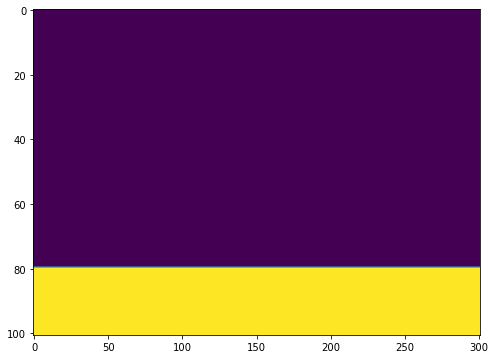

In [48]:
test_model.draw_model()

In [49]:
dt = 0.001
pml_layer = 10
pml_max = (1200, 1200, 2, 2, 150, 150)

In [50]:
test_pml_model = PML_Model(dt, model_size, array_size, vp_model, vs_model, pho_model, pml_layer, pml_max)

<ipython-input-46-5fe24ccfe8f1>:51: RuntimeWarning: invalid value encountered in true_divide
  self._a_x = np.where(sigma_x==0, 0, (1 - self._b_x) * sigma_x / (kai_x * (kai_x * alpha_x + sigma_x)))
<ipython-input-46-5fe24ccfe8f1>:54: RuntimeWarning: invalid value encountered in true_divide
  self._a_z = np.where(sigma_z==0, 0, (1 - self._b_z) * sigma_z / (kai_z * (kai_z * alpha_z + sigma_z)))


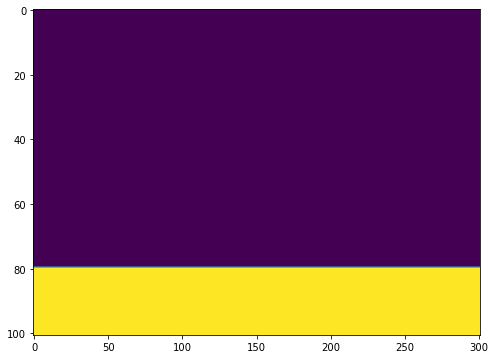

In [51]:
test_pml_model.draw_model()